In [2]:
%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler




In [3]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


c:\Users\oscar.azrak\Desktop\Master-thesis\Master-thesis\Files\func.py:23: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [4]:
windows = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [5]:
target_days = 10

return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift)

In [6]:
X_train, X_eval, X_test, y_train, y_eval, y_test, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [7]:
# load all models

"""NN_model = load_model('NN_model.h5')
ridge_best = pickle.load(open('ridge_model.pickle', 'rb'))
lgb_best = pickle.load(open('lgb_model.pickle', 'rb'))
xgb_best = pickle.load(open('xgb_model.pickle', 'rb'))"""
NN_model, history, X_test_scaled = train_and_evaluate_NN(X_train_eval, y_train_eval, X_eval, y_eval, X_test, y_test)

param_grid_alpha = {'alpha': 10.0}
ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_train_eval, y_train_eval, param_grid_alpha)

param_grid_xgb =  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

xgb_best, best_params = optimize_and_train_xgb(X_train, y_train, X_eval, y_eval, param_grid_xgb)

param_grid_lgb =  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31}

lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb)



C:\Users\oscar.azrak\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5139 - loss: 0.2498 - val_accuracy: 0.5350 - val_loss: 0.2483
Epoch 2/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5315 - loss: 0.2485 - val_accuracy: 0.5454 - val_loss: 0.2473
Epoch 3/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5400 - loss: 0.2475 - val_accuracy: 0.5497 - val_loss: 0.2466
Epoch 4/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5446 - loss: 0.2468 - val_accuracy: 0.5531 - val_loss: 0.2458
Epoch 5/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5505 - loss: 0.2459 - val_accuracy: 0.5586 - val_loss: 0.2449
Epoch 6/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5521 - loss: 0.2456 - val_accuracy: 0.5577 - val_loss: 0.2454
Epoch 7/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5574 - loss: 0.2447 - val_accuracy: 0.5619 - val_loss: 0.2438
Epoch 8/50
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.5620 - loss: 0.2437 

In [8]:
# Store predictions in a dictionary
predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "XGBoost Classifier": xgb_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 6s 903us/step
Ridge Classifier:
Accuracy: 0.5155106630994624
Confusion Matrix:
[[78919 20353]
 [73995 21470]]
Precision: 51.335389618152696
Recall: 22.489917770910807
F1 Score: 31.277314841792435
MSE: 48.448933690053764
RMSE: 69.60526825611245


XGBoost Classifier:
Accuracy: 0.5136363402948593
Confusion Matrix:
[[52887 46385]
 [48328 47137]]
Precision: 50.40204443874169
Recall: 49.3762111768711
F1 Score: 49.883854445014734
MSE: 48.63636597051408
RMSE: 69.73977772441928


LightGBM Classifier:
Accuracy: 0.5177906612508152
Confusion Matrix:
[[55333 43939]
 [49965 45500]]
Precision: 50.872661814197386
Recall: 47.66144660346724
F1 Score: 49.2147276424523
MSE: 48.22093387491848
RMSE: 69.44129454072589


Neural Network:
Accuracy: 0.5088812090152359
Confusion Matrix:
[[52507 46765]
 [48874 46591]]
Precision: 49.90680834654441
Recall: 4

In [9]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)


In [10]:
results_best = {}
results_worst = {}
models = {
    'lgb': lgb_best,
    'xgb': xgb_best,
    'ridge': ridge_best,
    'NN': NN_model
}

df_2_neutral = df_2_read.copy()

for col in df_2_neutral.columns:
    df_2_neutral[col] = 0  


model_dfs = {
    'lgb': df_2_neutral.copy(),
    'xgb': df_2_neutral.copy(),
    'ridge': df_2_neutral.copy(),
    'NN': df_2_neutral.copy()
}


In [11]:
def calculate_annualized_volatility(df, window=252):
    """Calculate the rolling annualized volatility for each asset in the dataframe."""
    volatilities = df.copy()
    volatilities.fillna(0, inplace=True)


    return volatilities.rolling(window=window).std() * np.sqrt(window)

volatilities = calculate_annualized_volatility(df_read)


In [12]:


"""def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):

    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date
        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days
        
        # Normalization factor to ensure absolute sum of values is 1
        num_assets = len(assets)
        if num_assets > 0:
            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets

        for asset in assets:
            if asset in df.columns:
                df.loc[start_date:end_date, asset] = value

# Gather all best and worst assets for each date for each model
portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', target_days)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', target_days)"""


"def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days):\n\n    for date_str, assets in portfolios.items():\n        start_date = pd.to_datetime(date_str) + pd.DateOffset(days=2)  # Start two days after the given date\n        end_date = start_date + pd.DateOffset(days=hold_days - 1)  # Hold for hold_days\n        \n        # Normalization factor to ensure absolute sum of values is 1\n        num_assets = len(assets)\n        if num_assets > 0:\n            value = 1 / num_assets if portfolio_type == 'best' else -1 / num_assets\n\n        for asset in assets:\n            if asset in df.columns:\n                df.loc[start_date:end_date, asset] = value\n\n# Gather all best and worst assets for each date for each model\nportfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\nportfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}\n\n\n\nfor name, model in models.items():\n    best_assets, worst_assets = predict_and_analyze_ext(model, X_test

In [13]:


def update_df_with_asset_performance(df, portfolios, portfolio_type, hold_days, volatilities):
    """Update df by marking assets in portfolios with inverse volatility weighted values 
    starting two days after for a duration, such that the absolute sum of values is 1."""
    
    for date_str, assets in portfolios.items():
        start_date = pd.to_datetime(date_str).normalize() + pd.DateOffset(days=2)
        end_date = start_date + pd.DateOffset(days=hold_days - 1)

        if start_date in volatilities.index:
            if portfolio_type == 'best':
                # Get volatilities for the assets at the start date
                asset_vols = volatilities.loc[start_date, assets].dropna()
                if not asset_vols.empty:
                    weights = 1 / asset_vols
                    total_weight = weights.sum()
                    normalized_weights = weights / total_weight  # Normalize weights

                    # Assign weights to assets in the DataFrame
                    for asset, weight in normalized_weights.items():
                        if asset in df.columns:
                            df.loc[start_date:end_date, asset] = weight
            else:
                num_assets = len(assets)
                if num_assets > 0:
                    value = -1 / num_assets
                    for asset in assets:
                        if asset in df.columns:
                            df.loc[start_date:end_date, asset] = value




portfolios_best = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}
portfolios_worst = { 'lgb': {}, 'xgb': {}, 'ridge': {}, 'NN': {}}



for name, model in models.items():
    best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name) 

    # Accumulate best and worst assets for each date
    for date in best_assets['todate'].unique():
        portfolios_best[name].setdefault(date, []).extend(best_assets[best_assets['todate'] == date]['asset'].tolist())
        portfolios_worst[name].setdefault(date, []).extend(worst_assets[worst_assets['todate'] == date]['asset'].tolist())

   
    update_df_with_asset_performance(model_dfs[name], portfolios_best[name], 'best', target_days, volatilities)
    update_df_with_asset_performance(model_dfs[name], portfolios_worst[name], 'worst', target_days, volatilities)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 5s 825us/step


In [14]:
xgb_weights = model_dfs['xgb']
lgb_weights = model_dfs['lgb']
ridge_weights = model_dfs['ridge']
NN_weights = model_dfs['NN']




xgb_returns = xgb_weights*df_2_read
lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read


In [16]:


xgb_trade_volume = calculate_trade_volume(xgb_weights)
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)



In [17]:
xgb_trade_volume.sum()

33740

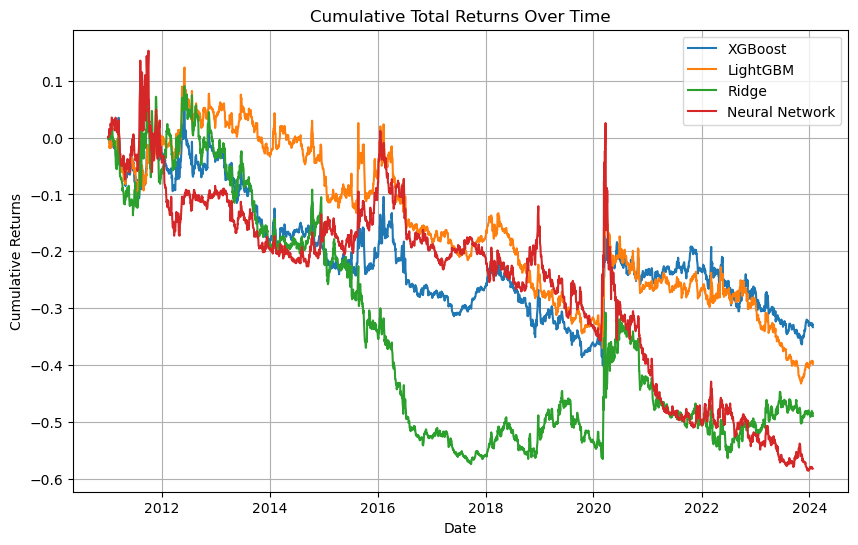

In [18]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
xgb_total_returns = xgb_returns.sum(axis=1)
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)

# Calculate the cumulative total returns for each model
xgb_cumulative_total_returns = (1 + xgb_total_returns).cumprod() - 1
lgb_cumulative_total_returns = (1 + lgb_total_returns).cumprod() - 1
ridge_cumulative_total_returns = (1 + ridge_total_returns).cumprod() - 1
NN_cumulative_total_returns = (1 + NN_total_returns).cumprod() - 1

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(xgb_cumulative_total_returns, label='XGBoost')
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [19]:
#print trade volume
print("XGBoost trade volume:")
print(xgb_trade_volume.sum())
print("\n")
print("LightGBM trade volume:")
print(lgb_trade_volume.sum())
print("\n")
print("Ridge trade volume:")
print(ridge_trade_volume.sum())
print("\n")
print("Neural Network trade volume:")
print(NN_trade_volume.sum())
print("\n")

XGBoost trade volume:
33740


LightGBM trade volume:
32587


Ridge trade volume:
34626


Neural Network trade volume:
34092




In [23]:
ridge_metrics = financial_metrics(ridge_total_returns)
lgb_metrics = financial_metrics(lgb_total_returns)
xgb_metrics = financial_metrics(xgb_total_returns)
NN_metrics = financial_metrics(NN_total_returns)

In [24]:
print("Ridge metrics:")
print(ridge_metrics)
print("\n")
print("LightGBM metrics:")
print(lgb_metrics)
print("\n")
print("XGBoost metrics:")
print(xgb_metrics)
print("\n")
print("Neural Network metrics:")
print(NN_metrics)


Ridge metrics:
{'Average Yearly Return': -0.03311892197676517, 'Average Yearly Standard Deviation': 0.18742389622358369, 'Sharpe Ratio': -0.17670597316607162, 'Max Drawdown': -8.929855920276147, 'Volatility': 0.18742389622358369, 'Calmar Ratio': -0.0037087857040968924, 'Skewness': 1.2373361981251139, 'Kurtosis': 33.23926440115732}


LightGBM metrics:
{'Average Yearly Return': -0.0307754372331427, 'Average Yearly Standard Deviation': 0.12226174337961207, 'Sharpe Ratio': -0.25171763776987577, 'Max Drawdown': -7.96060287576172, 'Volatility': 0.12226174337961207, 'Calmar Ratio': -0.003865968157618705, 'Skewness': 2.306184449246648, 'Kurtosis': 35.39544280365372}


XGBoost metrics:
{'Average Yearly Return': -0.022610668634444102, 'Average Yearly Standard Deviation': 0.12601582575737305, 'Sharpe Ratio': -0.17942721478473647, 'Max Drawdown': -8.242700678507205, 'Volatility': 0.12601582575737305, 'Calmar Ratio': -0.0027431141219771927, 'Skewness': 2.165515607142032, 'Kurtosis': 36.280440879276

In [43]:



def calculate_momentum_based_benchmark(df, windows=[252, 126, 63]):
    
    features_df = add_features(df, windows)
    features_df = transform_and_pivot_df(features_df, date_col)
    # First, filter out necessary columns for each window
    momentum_cols = {w: [col for col in df.columns if f'momentum_{w}' in col] for w in windows}
    
    # Initialize DataFrame to hold ranks for each window
    ranks_df = pd.DataFrame(index=df.index)

    # Calculate ranks for each momentum metric
    for w in momentum_cols:
        df[f'rank_momentum_{w}'] = df[momentum_cols[w]].mean(axis=1).rank(ascending=False)
        ranks_df = pd.concat([ranks_df, df[[f'rank_momentum_{w}']]], axis=1)

    # Calculate average rank across all selected windows
    ranks_df['average_rank'] = ranks_df.mean(axis=1)

    # Determine long and short positions
    long_threshold = ranks_df['average_rank'].quantile(0.20)
    short_threshold = ranks_df['average_rank'].quantile(0.80)
    ranks_df['long'] = ranks_df['average_rank'] <= long_threshold
    ranks_df['short'] = ranks_df['average_rank'] >= short_threshold

    # Calculate weights: longs +1, shorts -1, normalize to sum up to 1 in absolute terms
    ranks_df['weights'] = 0
    ranks_df.loc[ranks_df['long'], 'weights'] = 1 / ranks_df['long'].sum()
    ranks_df.loc[ranks_df['short'], 'weights'] = -1 / ranks_df['short'].sum()

    # Optionally, return only the necessary columns
    return ranks_df[['long', 'short', 'weights']]




In [44]:
benchmark_weights = calculate_momentum_based_benchmark(df_read)


C:\Users\oscar.azrak\AppData\Local\Temp\ipykernel_7900\964642210.py:27: RuntimeWarning: divide by zero encountered in longlong_scalars
  ranks_df.loc[ranks_df['long'], 'weights'] = 1 / ranks_df['long'].sum()
C:\Users\oscar.azrak\AppData\Local\Temp\ipykernel_7900\964642210.py:28: RuntimeWarning: divide by zero encountered in longlong_scalars
  ranks_df.loc[ranks_df['short'], 'weights'] = -1 / ranks_df['short'].sum()


In [49]:
benchmark_weights.tail(1000)

,long,short,weights
todate,,,
2020-03-24,False,False,0.0
2020-03-25,False,False,0.0
2020-03-26,False,False,0.0
2020-03-27,False,False,0.0
2020-03-30,False,False,0.0
2020-03-31,False,False,0.0
2020-04-01,False,False,0.0
2020-04-02,False,False,0.0
2020-04-03,False,False,0.0
